In [8]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
import torchvision.utils as vutils
from torchvision.utils import make_grid
import pandas as pd
from IPython.display import HTML
from tqdm.auto import tqdm

def is_cuda():
    if torch.cuda.is_available():
        print("CUDA available")
    else:
        print("No CUDA. Working on CPU.")
        
is_cuda()

CUDA available


In [9]:
root = "/kaggle/input/anime-pictures/images"
batch_size = 128
image_size = 64
nc = 3 # n channels
nz = 512 # n latent dim
ngf = 64 # size of generator feature map
ndf = 64 # size of discriminator feature map
n_epochs = 130
lr = 0.0002
beta1 = 0.05
ngpu = 1

In [10]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64)):

    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.figure(figsize=(8,8))
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()
    
def to_rgb(img):
    rgb_img = Image.new("RGB", img.size)
    rgb_img.paste(img)
    return rgb_img

class ImageSet(Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
        self.imgs = sorted(glob.glob(os.path.join(root, "*.*")))
        
    def __getitem__(self, index):
        img = Image.open(self.imgs[index % len(self.imgs)])
        img = to_rgb(img)
        img = self.transform(img)
        return img
    
    def __len__(self):
        return len(self.imgs)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


dataset = ImageSet(root=root, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

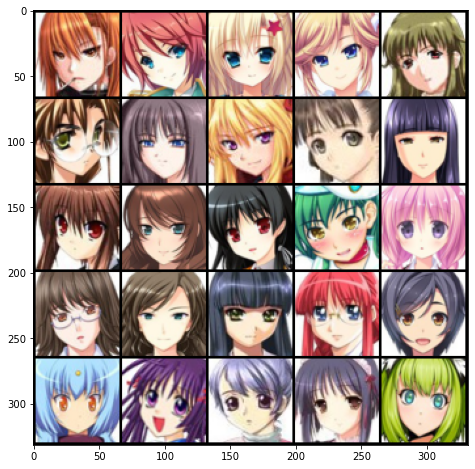

In [11]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu>0) else "cpu")

real_batch = next(iter(dataloader))
show_tensor_images(real_batch)

In [12]:
# Weight Initialization following the literature
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, first=False):
        super().__init__()
        
        if first:
        
            self.mapping_block = nn.Sequential(
                nn.Linear(in_channel, in_channel),
                nn.Linear(in_channel, in_channel)
            )
            
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.utils.spectral_norm(nn.Conv2d(in_channel//16, out_channel, 3, 1, 1)),
                nn.InstanceNorm2d(out_channel),
                nn.ReLU(),
                nn.utils.spectral_norm(nn.Conv2d(out_channel, out_channel, 3, 1, 1)),
                nn.InstanceNorm2d(out_channel),
                nn.ReLU()
            )
        
        else:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.utils.spectral_norm(nn.Conv2d(in_channel, out_channel, 3, 1, 1)),
                nn.InstanceNorm2d(out_channel),
                nn.ReLU(),
                nn.utils.spectral_norm(nn.Conv2d(out_channel, out_channel, 3, 1, 1)),
                nn.InstanceNorm2d(out_channel),
                nn.ReLU()
        )
        
        self.first = first

        self.upsample = nn.Upsample(scale_factor=2)
    
    def forward(self, x):
        if self.first:
            x = self.mapping_block(x) # N x 512
            h = x.view(-1, 32, 4, 4) # N x 32 x 4 x 4
            h = self.block(h)
            y = 0 # identity
        else:
            h = self.block(x)
            y = self.upsample(x)

        return h+y
        

class Generator(nn.Module):
    def __init__(self, in_channel, hidden_channel):
        super(Generator, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        n_blocks = 3 # To make images 64 x 64
        g = [ResBlock(in_channel, hidden_channel, first=True)]
        for _ in range(n_blocks):
            g += [ResBlock(hidden_channel, hidden_channel)]
        g += [nn.Conv2d(hidden_channel, 3, 3, 1, 1)]
        self.G = nn.Sequential(*g)
        self.activation = nn.Tanh()
        
    def forward(self, x):
        x = self.G(x)
        return self.activation(x)

In [14]:
G = Generator(512, 64).to(device)

if (device.type=='cuda') and (ngpu>1):
    G = nn.DataParallel(G, list(range(ngpu)))

G.apply(weights_init)

print(G)

Generator(
  (upsample): Upsample(scale_factor=2.0, mode=nearest)
  (G): Sequential(
    (0): ResBlock(
      (mapping_block): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): Linear(in_features=512, out_features=512, bias=True)
      )
      (block): Sequential(
        (0): Upsample(scale_factor=2.0, mode=nearest)
        (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (6): ReLU()
      )
      (upsample): Upsample(scale_factor=2.0, mode=nearest)
    )
    (1): ResBlock(
      (block): Sequential(
        (0): Upsample(scale_factor=2.0, mode=nearest)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [15]:
class dResBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.block = nn.Sequential(
            nn.AvgPool2d(2, 2),#match
            nn.utils.spectral_norm(nn.Conv2d(in_channel, out_channel, 3, 1, 1)),
            nn.InstanceNorm2d(out_channel),
            nn.LeakyReLU(negative_slope=0.2),
            nn.utils.spectral_norm(nn.Conv2d(out_channel, out_channel, 3, 1, 1)),
            nn.InstanceNorm2d(out_channel),
            nn.LeakyReLU(negative_slope=0.2)
        )
        self.downsample = nn.AvgPool2d(2,2)#match
        
    def forward(self, x):
        h = self.block(x)
        y = self.downsample(x)
        return h+y
    
class auxDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, 3, 1, 1),
            nn.InstanceNorm2d(3),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.decoder(x)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        
        d = [nn.Conv2d(3, 64, 3, 1, 1)] # 64 x 64
        for _ in range(4):
            d += [dResBlock(64, 64)]
        d += [nn.Conv2d(64, 1, kernel_size=4, stride=1, padding=0)]
        self.D = nn.Sequential(*d)
        self.Encoder = nn.Sequential(*d[:3]) # 64 x 16 x 16
        self.Decoder = auxDecoder()
        
    def forward(self, x):
        return self.D(x)
    
    def reconstruct(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x

In [16]:
D = Discriminator(ngpu).to(device)

if (device.type=="cuda") and (ngpu>1):
    D = nn.DataParellel(G, list(range(ngpu)))
    
D.apply(weights_init)

print(D)

Discriminator(
  (D): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): dResBlock(
      (block): Sequential(
        (0): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): LeakyReLU(negative_slope=0.2)
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (6): LeakyReLU(negative_slope=0.2)
      )
      (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (2): dResBlock(
      (block): Sequential(
        (0): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_runn

In [17]:
criterion = nn.BCEWithLogitsLoss()
recon_criterion = nn.MSELoss()
fixed_noise = torch.randn(64, 512, device=device)

real_label = 1.
fake_label = 0.

optimD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

In [18]:
from torchvision.models import inception_v3
from torch.distributions import MultivariateNormal
import scipy
from scipy import linalg

inception = inception_v3(pretrained=True)
inception.fc = nn.Identity()
inception.to(device)

# resnet = models.resnet50(pretrained=True)
def matrix_sqrt(x):
    y = x.cpu().detach().numpy()
    y = linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

def frechet_distance(mu_x, mu_y, sig_x, sig_y):
    return torch.norm(mu_x-mu_y).pow(2) + torch.trace(sig_x+sig_y-2*matrix_sqrt(torch.matmul(sig_x, sig_y)))

def preprocess(img):
    return F.interpolate(img, size=(299,299), mode='bilinear', align_corners=False)

def get_cov(x):
    return torch.Tensor(np.cov(x.detach().numpy(), rowvar=False))

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

[3/130][1000/497]	Loss_D: 1.1948	Loss_G: 1.6252	D(x): 0.2063	D(G(z)): -0.8713 / -1.3885


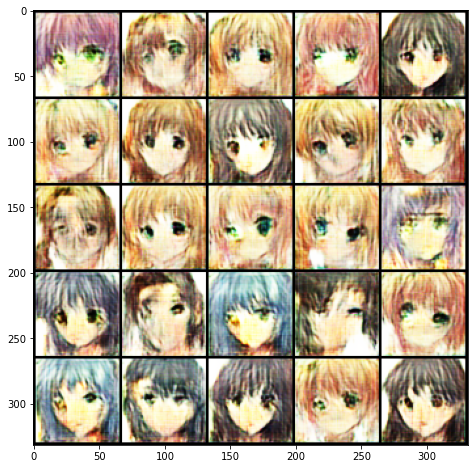

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

[5/130][2000/497]	Loss_D: 0.9253	Loss_G: 1.6427	D(x): 0.7269	D(G(z)): -1.9422 / -1.3508


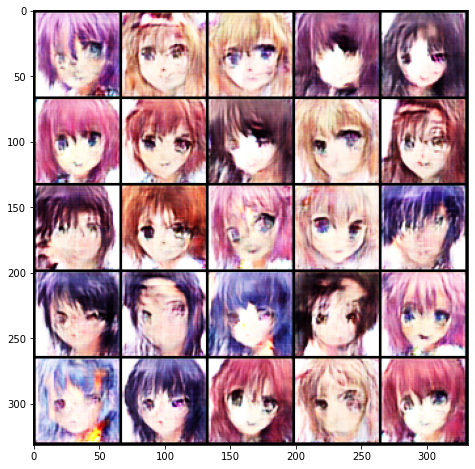

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

[7/130][3000/497]	Loss_D: 1.0467	Loss_G: 2.1302	D(x): 0.9248	D(G(z)): -2.4135 / -1.7613


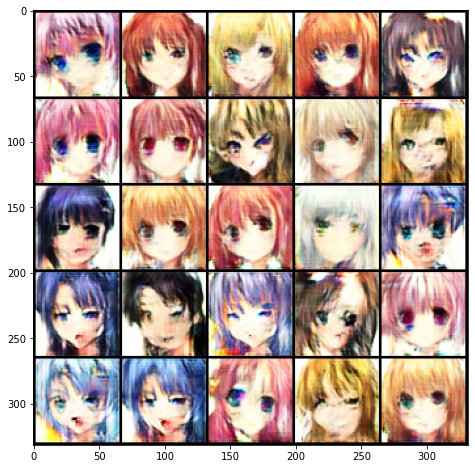

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

[9/130][4000/497]	Loss_D: 0.4331	Loss_G: 2.9837	D(x): 3.4806	D(G(z)): -2.2419 / -2.9119


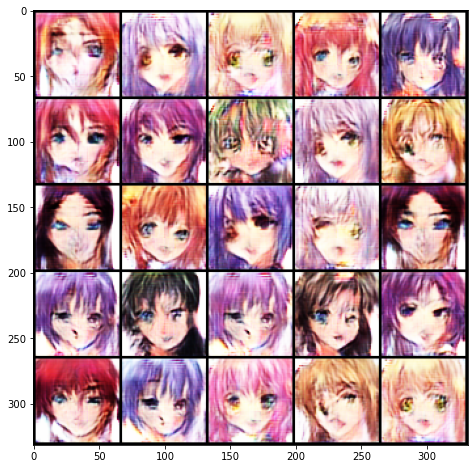

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

[11/130][5000/497]	Loss_D: 0.5458	Loss_G: 2.9639	D(x): 2.2493	D(G(z)): -2.9722 / -2.8849


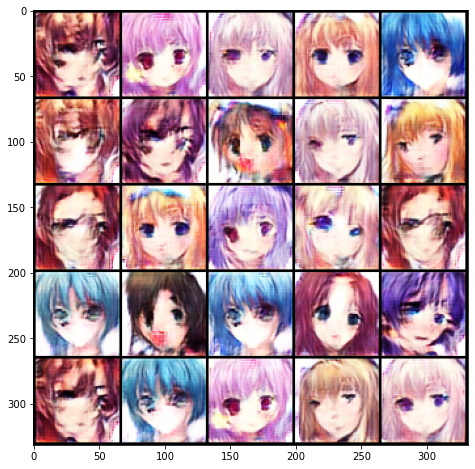

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

[13/130][6000/497]	Loss_D: 0.7157	Loss_G: 3.3576	D(x): 2.8632	D(G(z)): -1.0738 / -3.3067


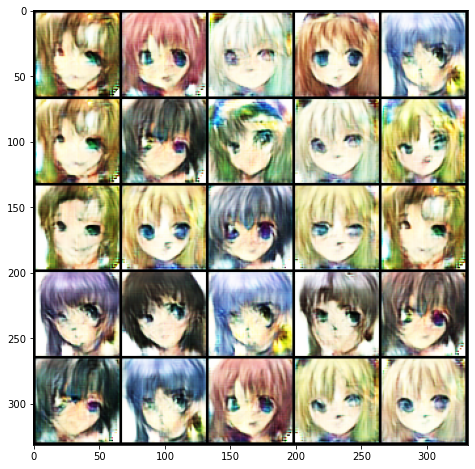

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

[15/130][7000/497]	Loss_D: 0.8026	Loss_G: 3.0670	D(x): 2.3962	D(G(z)): -0.8240 / -3.0091


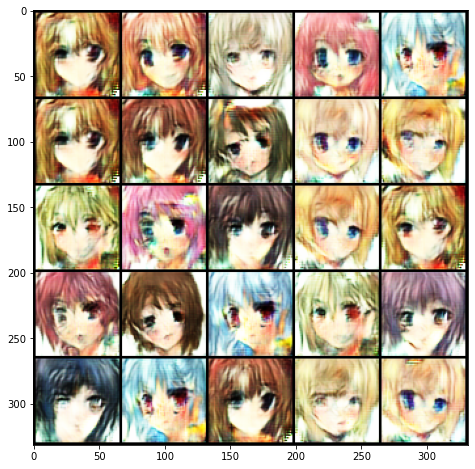

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

[17/130][8000/497]	Loss_D: 1.0864	Loss_G: 3.7316	D(x): 3.5403	D(G(z)): -0.1860 / -3.6955


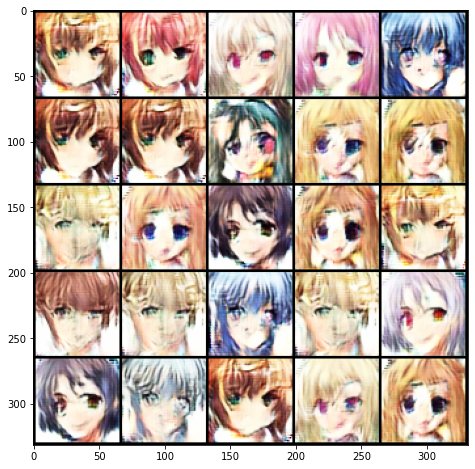

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

[19/130][9000/497]	Loss_D: 0.5613	Loss_G: 5.0616	D(x): 3.4712	D(G(z)): -2.0736 / -5.0498


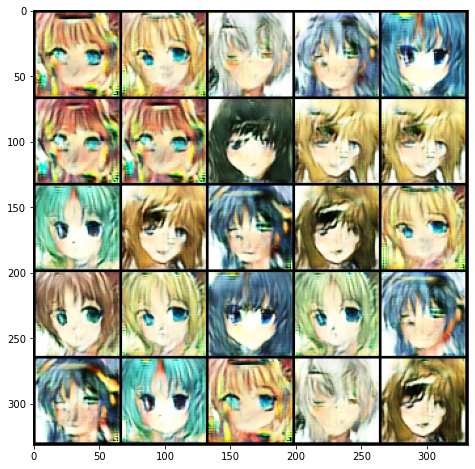

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

[21/130][10000/497]	Loss_D: 0.5994	Loss_G: 2.3985	D(x): 1.5381	D(G(z)): -3.2115 / -2.2607


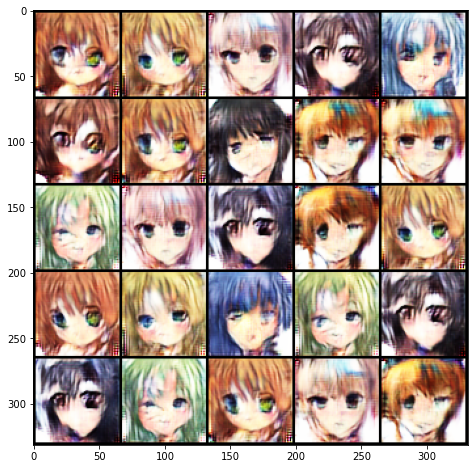

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

[23/130][11000/497]	Loss_D: 0.5540	Loss_G: 2.9479	D(x): 3.3818	D(G(z)): -1.2747 / -2.8809


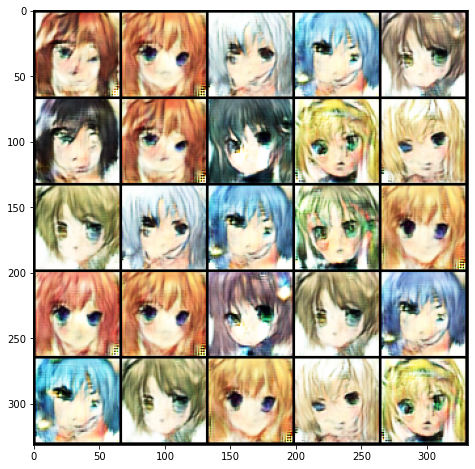

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

[25/130][12000/497]	Loss_D: 0.3299	Loss_G: 3.7829	D(x): 3.5191	D(G(z)): -4.1179 / -3.7483


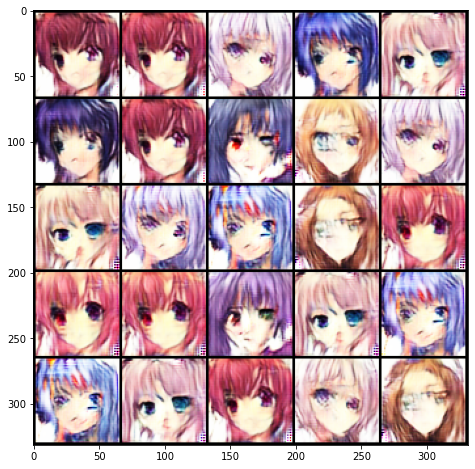

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

[27/130][13000/497]	Loss_D: 0.4754	Loss_G: 3.2594	D(x): 3.7703	D(G(z)): -1.9279 / -3.2095


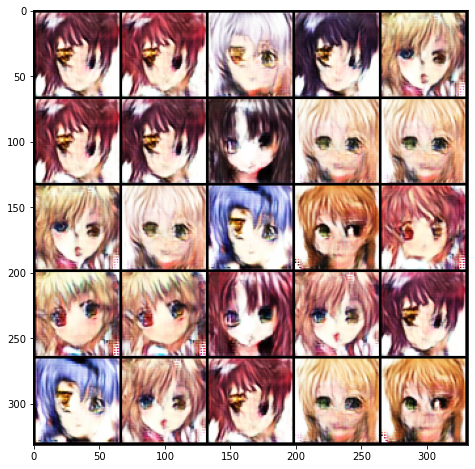

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

[29/130][14000/497]	Loss_D: 0.6245	Loss_G: 2.6213	D(x): 2.4034	D(G(z)): -3.6589 / -2.5217


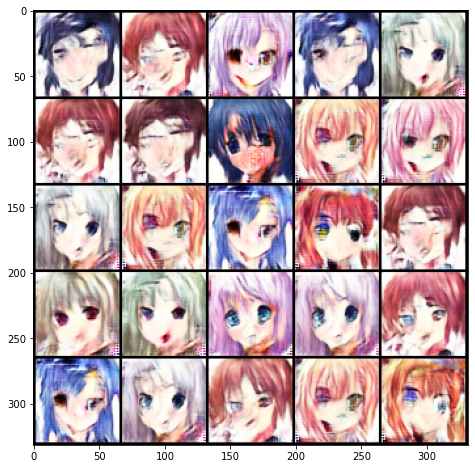

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

[31/130][15000/497]	Loss_D: 0.7746	Loss_G: 3.1692	D(x): 1.7566	D(G(z)): -4.4381 / -3.0994


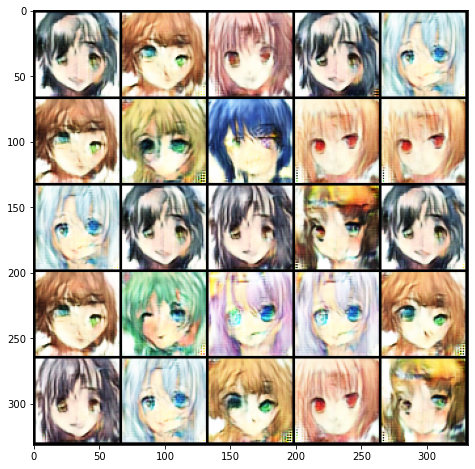

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [19]:
img_list, G_loss, D_loss = [], [], []
iters = 0

for epoch in range(n_epochs):
    for data in tqdm(dataloader):
        
        # Train Discriminator
        optimD.zero_grad()
        
        # First with real images
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = D(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        # Then Train with fake images
        noise = torch.randn(b_size, nz, device=device)
        fake_cpu = G(noise)
        label.fill_(fake_label)
        output = D(fake_cpu.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        # Self Supervised Learning with Auto-Encoding
        recon = D.reconstruct(real_cpu)
        err_recon = recon_criterion(recon, real_cpu)
        err_recon.backward()
        
        errD = errD_real + errD_fake + err_recon
        optimD.step()
        
        # Train Generator
        optimG.zero_grad()
        label.fill_(real_label)
        output = D(fake_cpu).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimG.step()
        
        if iters % 1000 == 999:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, n_epochs, iters+1, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
        G_loss.append(errG.item())
        D_loss.append(errD.item())
        
        if (iters % 1000==999) or ((epoch==n_epochs-1) and (iters==len(dataloader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
                show_tensor_images(fake)
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
torch.save(G.state_dict(), "G.pt")
torch.save(D.state_dict(), "D.pt")

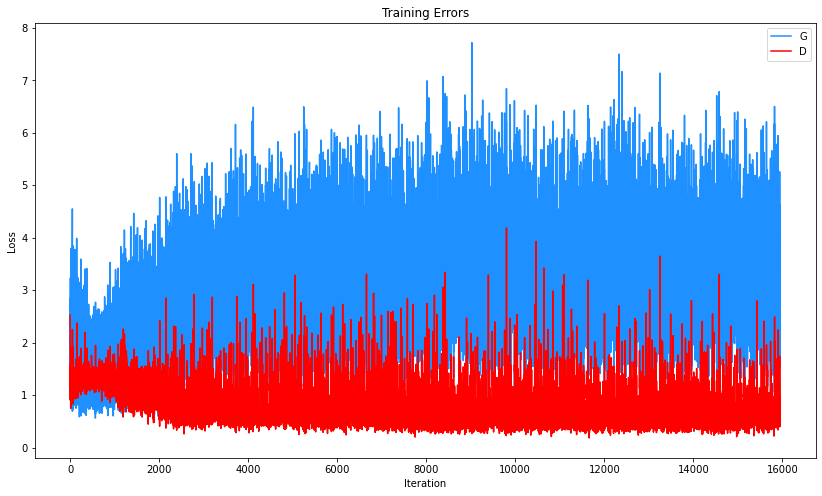

In [20]:
plt.figure(figsize=(14,8))
plt.title("Training Errors")
plt.plot(G_loss, label="G", color='dodgerblue')
plt.plot(D_loss, label="D", color='red')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [23]:
fake_features_all = torch.cat(fake_lst)
real_features_all = torch.cat(real_lst)

mu_fake = fake_features_all.mean(0)
mu_real = real_features_all.mean(0)
sigma_fake = get_cov(fake_features_all)
sigma_real = get_cov(real_features_all)

with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())

40.607479095458984
